In [267]:
import ccxt
import pandas as pd
import numpy as np
import talib

# Initialize Binance
exchange = ccxt.binance()

timeframe = '1h'  # hourly candles
limit = 100  # number of candles to fetch




In [268]:
exchange = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '15m'  # hourly candles
limit = 1000  # number of candles to fetch

# Fetch OHLCV data
ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)

# Convert to DataFrame
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

In [269]:
df.head()

,open,high,low,close,volume
timestamp,,,,,
2025-11-01 23:00:00,110092.79,110092.79,110001.52,110036.13,29.04067
2025-11-01 23:15:00,110036.13,110094.33,109996.05,110086.01,27.04663
2025-11-01 23:30:00,110086.02,110086.02,109974.00,110046.49,37.81535
2025-11-01 23:45:00,110046.48,110144.49,110013.67,110098.10,35.11326
2025-11-02 00:00:00,110098.10,110115.94,110030.54,110037.00,43.08063


In [270]:
df.shape

(1000, 5)

In [271]:
import ta  # pip install ta
import talib  # optional but used earlier; if missing remove DEMA or use pandas ewm

def add_features(df):
    df = df.copy()
    # ensure columns lower-case/consistent
    # expect df to contain 'open','high','low','close','volume' (case-insensitive)
    df.columns = [c.lower() for c in df.columns]

    # basic indicators (your current set)
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    df['ema12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['ema26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema12'] - df['ema26']
    df['signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['histogram'] = df['macd'] - df['signal']

    # DEMA (if talib available)
    try:
        df['dema9'] = talib.DEMA(df['close'].values, timeperiod=9)
    except Exception:
        df['dema9'] = df['close'].ewm(span=9).mean()  # fallback

    df['sma3'] = ta.trend.sma_indicator(df['close'], window=3)

    # TSI
    def compute_tsi(close, r1=25, r2=13):
        delta = close.diff()
        ema1 = delta.ewm(span=r1, adjust=False).mean()
        ema2 = ema1.ewm(span=r2, adjust=False).mean()
        abs_delta = delta.abs()
        abs_ema1 = abs_delta.ewm(span=r1, adjust=False).mean()
        abs_ema2 = abs_ema1.ewm(span=r2, adjust=False).mean()
        tsi = 100 * (ema2 / (abs_ema2.replace(0, np.nan)))
        return tsi.fillna(0)
    df['tsi'] = compute_tsi(df['close'])

    # Stochastic %K and %D
    period = 14; smooth_k = 3; smooth_d = 3
    lowest_low = df['low'].rolling(period).min()
    highest_high = df['high'].rolling(period).max()
    df['%k'] = 100 * (df['close'] - lowest_low) / (highest_high - lowest_low + 1e-8)
    df['%k'] = df['%k'].rolling(smooth_k).mean()
    df['%d'] = df['%k'].rolling(smooth_d).mean()

    # --- NEW HIGH-IMPACT features ---
    # ATR (volatility)
    df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
    # On-Balance Volume
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()
    # ADX (trend strength)
    df['adx'] = ta.trend.ADXIndicator(df['high'], df['low'], df['close'], window=14).adx()
    # CCI
    df['cci'] = ta.trend.cci(df['high'], df['low'], df['close'], window=20)

    # Price-derived features
    df['return_1'] = df['close'].pct_change()
    df['roll_mean_5'] = df['close'].rolling(5).mean()
    df['roll_std_5'] = df['close'].rolling(5).std()

    # drop rows with NaNs resulting from indicators
    df = df.dropna().reset_index(drop=True)
    return df
df = add_features(df)

In [272]:
df.head()  # Display the first few rows

,open,high,low,close,volume,rsi,ema12,ema26,macd,signal,...,tsi,%k,%d,atr,obv,adx,cci,return_1,roll_mean_5,roll_std_5
0,110023.22,110055.45,109962.06,110053.23,38.65021,54.230498,110021.146213,110025.067316,-3.921103,-6.086063,...,44.632736,36.731509,34.983009,110.884420,8.06736,0.0,-0.273506,0.000273,110020.872,24.330926
1,110053.22,110146.75,110030.06,110116.00,242.74623,61.549134,110035.739103,110031.803070,3.936033,-4.081644,...,44.521438,48.049516,39.737566,111.299104,250.81359,0.0,145.266360,0.000570,110040.918,48.430546
2,110116.00,110190.00,110038.67,110131.00,397.13785,63.068878,110050.394626,110039.150991,11.243635,-1.016588,...,44.656449,57.392767,47.391264,114.158454,647.95144,0.0,167.031784,0.000136,110061.778,61.479648
3,110131.00,110475.11,110079.48,110435.01,451.12074,80.173036,110109.566222,110068.473881,41.092341,7.405198,...,49.052967,73.412446,59.618243,134.263565,1099.07218,0.0,354.314848,0.002760,110151.692,164.446790
4,110435.01,110784.13,110426.58,110670.27,289.23805,85.694527,110195.828341,110113.051371,82.776971,22.479552,...,54.850148,82.039549,70.948254,150.212596,1388.31023,0.0,408.125539,0.002130,110281.102,263.084746


In [273]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [274]:
df.head()

,open,high,low,close,volume,rsi,ema12,ema26,macd,signal,...,tsi,%k,%d,atr,obv,adx,cci,return_1,roll_mean_5,roll_std_5
0,110023.22,110055.45,109962.06,110053.23,38.65021,54.230498,110021.146213,110025.067316,-3.921103,-6.086063,...,44.632736,36.731509,34.983009,110.884420,8.06736,0.0,-0.273506,0.000273,110020.872,24.330926
1,110053.22,110146.75,110030.06,110116.00,242.74623,61.549134,110035.739103,110031.803070,3.936033,-4.081644,...,44.521438,48.049516,39.737566,111.299104,250.81359,0.0,145.266360,0.000570,110040.918,48.430546
2,110116.00,110190.00,110038.67,110131.00,397.13785,63.068878,110050.394626,110039.150991,11.243635,-1.016588,...,44.656449,57.392767,47.391264,114.158454,647.95144,0.0,167.031784,0.000136,110061.778,61.479648
3,110131.00,110475.11,110079.48,110435.01,451.12074,80.173036,110109.566222,110068.473881,41.092341,7.405198,...,49.052967,73.412446,59.618243,134.263565,1099.07218,0.0,354.314848,0.002760,110151.692,164.446790
4,110435.01,110784.13,110426.58,110670.27,289.23805,85.694527,110195.828341,110113.051371,82.776971,22.479552,...,54.850148,82.039549,70.948254,150.212596,1388.31023,0.0,408.125539,0.002130,110281.102,263.084746


In [275]:
df.shape

(981, 23)

In [276]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def label_trend_by_slope(df, window=20, normalize_by_vol=True):
    """
    Professional trend labeling using rolling linear regression slope of log-price.
    Labels:
        1 -> Uptrend
        0 -> Downtrend
    """
    df = df.copy()
    log_price = np.log(df['close'])
    slopes = np.full(len(df), np.nan)

    for i in range(window, len(df)):
        y = log_price[i-window:i].values.reshape(-1, 1)
        x = np.arange(window).reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        slope = model.coef_[0][0]
        slopes[i] = slope

    # Optionally normalize by volatility (ATR or rolling std)
    if normalize_by_vol:
        vol = df['return_1'].rolling(window).std().values
        slopes = slopes / (vol + 1e-8)

    df['slope'] = slopes

    # Label based on slope sign
    df['trend_label'] = np.where(df['slope'] > 0, 1, 0)

    df = df.dropna().reset_index(drop=True)
    return df


In [277]:
df = label_trend_by_slope(df, window=5)


In [278]:
df.head()

,open,high,low,close,volume,rsi,ema12,ema26,macd,signal,...,%d,atr,obv,adx,cci,return_1,roll_mean_5,roll_std_5,slope,trend_label
0,110670.27,110714.04,110453.45,110512.00,396.05211,71.307514,110244.470135,110142.603121,101.867014,38.357045,...,79.662394,158.096696,992.25812,0.000000,246.638056,-0.001430,110372.856,242.975611,0.845904,1
1,110511.99,110596.74,110335.98,110456.80,185.80956,67.077704,110277.136268,110165.876964,111.259304,52.937497,...,79.764630,165.429789,806.44856,0.000000,152.448775,-0.000499,110441.016,196.208595,0.681015,1
2,110456.81,110515.29,110274.65,110485.13,296.98265,68.122804,110309.135304,110189.525337,119.609967,66.271991,...,74.657442,170.801947,1103.43121,0.000000,111.505505,0.000256,110511.842,93.201080,0.374398,1
3,110485.14,110568.04,110329.91,110497.98,382.72940,68.609555,110338.188334,110212.373831,125.814503,78.180493,...,68.526128,175.611094,1486.16061,26.275894,106.508094,0.000116,110524.436,84.026364,-0.078214,0
4,110497.98,110526.74,110375.78,110375.78,110.56641,59.331361,110343.971667,110224.477991,119.493676,86.443130,...,64.167500,173.850301,1375.59420,27.301651,80.284853,-0.001106,110465.538,54.147711,-0.455120,0


In [279]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_trend_labels(df, symbol='BTC/USDT'):
    plt.figure(figsize=(14, 7))

    # Always use index for x-axis
    x = df.index
    y = df['close']

    # Plot the price (base line)
    plt.plot(x, y, color='black', linewidth=1.5, label='Close Price')

    # Colored line segments for uptrend/downtrend
    for i in range(1, len(df)):
        color = 'limegreen' if df['trend_label'].iloc[i] == 1 else 'tomato'
        plt.plot(
            [x[i-1], x[i]],
            [y[i-1], y[i]],
            color=color,
            linewidth=2.5
        )

    # Make chart beautiful
    plt.title(f"{symbol} Trend Label Visualization", fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Price (USDT)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)

    # Format x-axis nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()


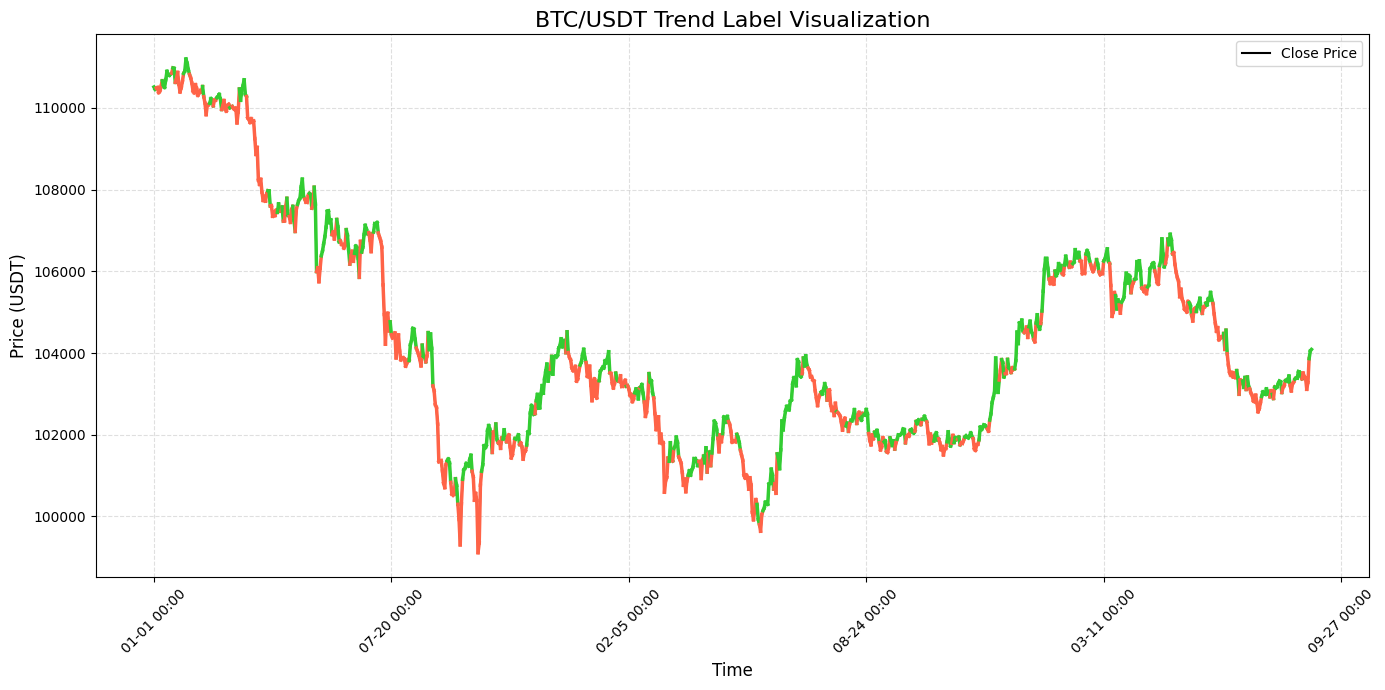

In [280]:
plot_trend_labels(df, symbol='BTC/USDT')

In [281]:
"""import numpy as np

def adaptive_triple_barrier_labeling(df, mult=1, max_period=10):
    
    Adaptive triple-barrier method based on volatility.
    - mult: how many standard deviations to use for barrier width
    - max_period: candles to look ahead
    
    df = df.copy()
    df['vol'] = df['close'].pct_change().rolling(20).std()
    labels = np.ones(len(df), dtype=int)
    close = df['close'].values

    for i in range(len(df) - max_period):
        if np.isnan(df['vol'].iloc[i]):
            continue

        # Dynamic upper/lower barriers based on volatility
        upper = close[i] * (1 + mult * df['vol'].iloc[i])
        lower = close[i] * (1 - mult * df['vol'].iloc[i])
        future_prices = close[i+1:i+max_period+1]

        if np.any(future_prices >= upper):
            labels[i] = 2
        elif np.any(future_prices <= lower):
            labels[i] = 0
        else:
            labels[i] = 1

    df['Label'] = labels
    return df
"""

"import numpy as np\n\ndef adaptive_triple_barrier_labeling(df, mult=1, max_period=10):\n\n    Adaptive triple-barrier method based on volatility.\n    - mult: how many standard deviations to use for barrier width\n    - max_period: candles to look ahead\n\n    df = df.copy()\n    df['vol'] = df['close'].pct_change().rolling(20).std()\n    labels = np.ones(len(df), dtype=int)\n    close = df['close'].values\n\n    for i in range(len(df) - max_period):\n        if np.isnan(df['vol'].iloc[i]):\n            continue\n\n        # Dynamic upper/lower barriers based on volatility\n        upper = close[i] * (1 + mult * df['vol'].iloc[i])\n        lower = close[i] * (1 - mult * df['vol'].iloc[i])\n        future_prices = close[i+1:i+max_period+1]\n\n        if np.any(future_prices >= upper):\n            labels[i] = 2\n        elif np.any(future_prices <= lower):\n            labels[i] = 0\n        else:\n            labels[i] = 1\n\n    df['Label'] = labels\n    return df\n"

In [282]:
df['Label'] = df['trend_label']

In [283]:
# =====================================
# 1️⃣ IMPORTS
# =====================================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import joblib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =====================================
# 2️⃣ FEATURE SETUP
# =====================================
FEATURES = [
    'rsi', 'ema12', 'ema26', 'macd', 'signal', 'histogram',
    'dema9', 'sma3', 'tsi', '%k', '%d',
    'atr', 'obv', 'adx', 'cci',
    'return_1', 'roll_mean_5', 'roll_std_5'
]

# Inputs and labels
X = df[FEATURES].values
y = df["Label"].values  # only 0 or 1

# =====================================
# 3️⃣ SCALING
# =====================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler_1m.pkl")
print("✅ Scaler saved as scaler_1m.pkl")


Using device: cpu
✅ Scaler saved as scaler_1m.pkl


In [284]:
# =====================================
# 4️⃣ CREATE SEQUENCES
# =====================================
def create_sequences(X, y, window_size=10):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.int64)

window_size = 10
X_seq, y_seq = create_sequences(X_scaled, y, window_size)
print(f"✅ Created sequences: {X_seq.shape}, Labels: {y_seq.shape}")


✅ Created sequences: (966, 10, 18), Labels: (966,)


In [285]:
# =====================================
# 5️⃣ TRAIN/TEST SPLIT
# =====================================
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [286]:
# =====================================
# 6️⃣ CLASS WEIGHTS
# =====================================
classes = np.unique(y_train.cpu())
weights = compute_class_weight('balanced', classes=classes, y=y_train.cpu().numpy())
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
print(f"✅ Class Weights: {class_weights.cpu().numpy()}")

✅ Class Weights: [0.9821883 1.0184697]


In [287]:
# =====================================
# 7️⃣ MODEL DEFINITION
# =====================================
class CryptoLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, output_dim=2):
        super(CryptoLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_dim = len(FEATURES)
output_dim = 2  # ⬅️ only two labels now
model = CryptoLSTM(input_dim=input_dim, output_dim=output_dim).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
print("✅ Binary LSTM model initialized.")

✅ Binary LSTM model initialized.


In [288]:
# =====================================
# 8️⃣ TRAINING LOOP
# =====================================
epochs = 300
batch_size = 32

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))
    total_loss = 0

    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / (X_train.size(0) // batch_size)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")


Epoch [1/300] - Loss: 0.7234
Epoch [10/300] - Loss: 0.2060
Epoch [20/300] - Loss: 0.0884
Epoch [30/300] - Loss: 0.0778
Epoch [40/300] - Loss: 0.0977
Epoch [50/300] - Loss: 0.0341
Epoch [60/300] - Loss: 0.0517
Epoch [70/300] - Loss: 0.0271
Epoch [80/300] - Loss: 0.0233
Epoch [90/300] - Loss: 0.0087
Epoch [100/300] - Loss: 0.0397
Epoch [110/300] - Loss: 0.0189
Epoch [120/300] - Loss: 0.0460
Epoch [130/300] - Loss: 0.0038
Epoch [140/300] - Loss: 0.0179
Epoch [150/300] - Loss: 0.0502
Epoch [160/300] - Loss: 0.0166
Epoch [170/300] - Loss: 0.0005
Epoch [180/300] - Loss: 0.1030
Epoch [190/300] - Loss: 0.0010
Epoch [200/300] - Loss: 0.0012
Epoch [210/300] - Loss: 0.0003
Epoch [220/300] - Loss: 0.0001
Epoch [230/300] - Loss: 0.0813
Epoch [240/300] - Loss: 0.0140
Epoch [250/300] - Loss: 0.0017
Epoch [260/300] - Loss: 0.0122
Epoch [270/300] - Loss: 0.0178
Epoch [280/300] - Loss: 0.0006
Epoch [290/300] - Loss: 0.0003
Epoch [300/300] - Loss: 0.0087


In [289]:
# =====================================
# 9️⃣ EVALUATION
# =====================================
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    preds = torch.argmax(outputs, dim=1)
    accuracy = (preds == y_test).float().mean().item()

print(f"✅ Test Accuracy: {accuracy:.4f}")


✅ Test Accuracy: 0.9124


In [290]:
# =====================================
# 🔟 SAVE MODEL
# =====================================
torch.save(model.state_dict(), "greg_tech_binary.pth")
print("✅ Model saved successfully as greg_tech_binary.pth")


✅ Model saved successfully as greg_tech_binary.pth


In [291]:
# =====================================
# 1️⃣1️⃣ PREDICTIONS ON FULL DATA
# =====================================
model.eval()
predictions = []
with torch.no_grad():
    for i in range(window_size, len(X_scaled)):
        X_input = torch.tensor(X_scaled[i-window_size:i], dtype=torch.float32).unsqueeze(0).to(device)
        output = model(X_input)
        pred_label = torch.argmax(output, dim=1).item()
        predictions.append(pred_label)

# Pad the start (since first window cannot be predicted)
df["Predicted"] = [1]*window_size + predictions
print("✅ Predictions added to DataFrame")

✅ Predictions added to DataFrame


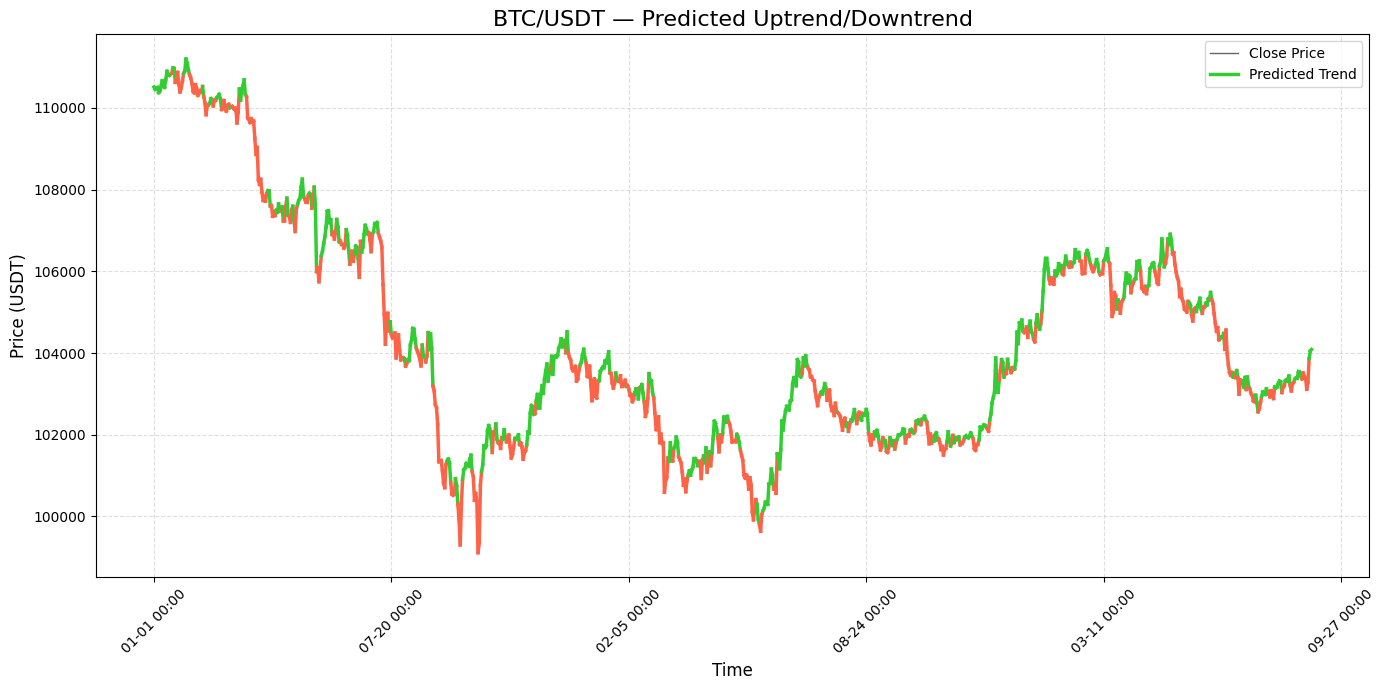

In [292]:
# =====================================
# 1️⃣2️⃣ VISUALIZATION
# =====================================
def plot_predicted_trends(df, symbol='BTC/USDT'):
    plt.figure(figsize=(14, 7))
    x, y = df.index, df['close']

    plt.plot(x, y, color='black', linewidth=1, alpha=0.6, label='Close Price')

    for i in range(1, len(df)):
        label = df['Predicted'].iloc[i]
        color = 'limegreen' if label == 1 else 'tomato'
        plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=color, linewidth=2.5)

    plt.title(f"{symbol} — Predicted Uptrend/Downtrend", fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Price (USDT)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(['Close Price', 'Predicted Trend'])
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_predicted_trends(df, symbol='BTC/USDT')
